In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from google.colab.patches import cv2_imshow
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D
import os

SIZE = 512 #Resize images

In [ ]:
path = glob.glob("/content/drive/MyDrive/New folder/*.png")
path.sort()

In [ ]:
train_images = []


for img_path in path:
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))
  # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)
        #train_labels.append(label)

train_images = np.array(train_images)


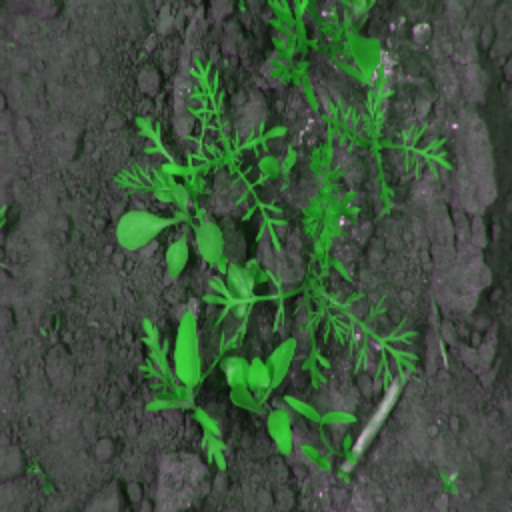

In [ ]:
cv2_imshow(train_images[0])

In [ ]:
np.shape(train_images)

(10, 512, 512, 3)

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/New folder (2)/*.png")
path1.sort()
print(len(path1))

10


In [ ]:
train_masks = []

for img_path1 in path1:
  mask = cv2.imread(img_path1, 0)
  mask = cv2.resize(mask, (SIZE, SIZE), interpolation = cv2.INTER_NEAREST)
  # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
  train_masks.append(mask)
  #train_labels.append(label)

In [ ]:
np.shape(train_masks)

(10, 512, 512)

In [ ]:
train_masks = np.array(train_masks)

X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3)


In [ ]:
activation = 'sigmoid'
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE,3)))
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(tf.keras.layers.BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))

In [ ]:

X = feature_extractor.predict(X_train)

X = X.reshape(-1, X.shape[3])

Y = y_train.reshape(-1)


In [ ]:
np.shape(X)

(2621440, 64)

In [ ]:
np.shape(Y)

(2621440,)

In [ ]:
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

##If we do not want to include pixels with value 0
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]

X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']


[  0 149  76]
0      2379296
76      196068
149      46076
Name: Label, dtype: int64


In [ ]:
np.shape(X_for_RF)

(242144, 64)

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
# Ravel Y to pass 1d array instead of column vector
model.fit(X_for_RF, Y_for_RF) #For sklearn no one hot encoding


RandomForestClassifier(random_state=42)

In [ ]:
filename = '/content/drive/MyDrive/RF_model4.sav'
pickle.dump(model, open(filename, 'wb'))


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))



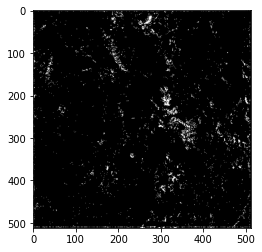

In [ ]:
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/007_image.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE, SIZE))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = feature_extractor.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')



In [ ]:

#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/007_image.png',0)
test_img = cv2.resize(test_img, (SIZE, SIZE))
# test_img = cv2.cvtColor(test_img)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = feature_extractor.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)
